In [225]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data

In [2]:
charting_df = pd.read_csv('data/charting-m-points.csv', encoding = "ISO-8859-1")

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/2249881497.py:1: DtypeWarning: Columns (8,9,29) have mixed types. Specify dtype option on import or set low_memory=False.
  charting_df = pd.read_csv('data/charting-m-points.csv', encoding = "ISO-8859-1")


In [3]:
charting_df.head(1)

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,1,0,0,0.0,0.0,0-0,1 (1),1,0,...,NaN,False,False,False,False,False,False,1,1,1


### Exploration

In [339]:
wimbeldon_chart_df = charting_df[charting_df['match_id'].str.contains('Wimbledon')]

#### Winning Shot Statistics

In [5]:
# get rows for both 1st and 2nd
wimbeldon_chart_1st = wimbeldon_chart_df[wimbeldon_chart_df['1st'].notna()]
wimbeldon_chart_2nd = wimbeldon_chart_df[wimbeldon_chart_df['2nd'].notna()]

In [6]:
rallys = wimbeldon_chart_1st['1st']
rallys = rallys.append(wimbeldon_chart_2nd['2nd'])

In [7]:
rallys.shape

(78705,)

In [8]:
# sequences of rallies that end with '*' represent a winner was hit
# winners_df_1st = wimbeldon_chart_1st[wimbeldon_chart_1st['1st'].str.contains("\*")]
# winners_df_2nd = wimbeldon_chart_2nd[wimbeldon_chart_2nd['2nd'].str.contains("\*")]
winning_shots = rallys[rallys.str.contains("\*")]

In [9]:
#winners_df = winners_df_1st['1st']
#winners_df = winners_df.append(winners_df_2nd['2nd'])

In [10]:
winning_shots.shape

(20290,)

In [11]:
# 1st value: winners
# 2nd value: total occurences of this shot selection in general
shot_map = {
    'f': [0, 0,'fh gs'],
    'b': [0, 0,'bh gs'],
    'r': [0, 0, 'fh slice'],
    's': [0, 0, 'bh slice'],
    'v': [0, 0,'fh volley'],
    'z': [0, 0,'bh volley'],
    'o': [0, 0,'oh smash'],
    'p': [0, 0,'bh smash'],
    'u': [0, 0,'fh drop'],
    'y': [0, 0,'bh drop'],
    'l': [0, 0,'fh lob'],
    'm': [0, 0,'bh lob'],
    'h': [0, 0,'fh hv'],
    'i': [0, 0,'bh hv'],
    'j': [0, 0,'fh sv'],
    'k': [0, 0,'bh sv'],
    't': [0, 0,'trickshot'],
    'q': [0, 0,'unknown'],
    'c': [0, 0,'challenge']
}

#### get winning shots

In [12]:
letter_regex = '[a-zA-Z]'

In [13]:
num_of_winning_shots = 0
for i in winning_shots:
    if len(i) > 2: # ignore aces for now
        winning_shot = i[-4:]
        match = re.search(r'{letter_regex}'.format(letter_regex=letter_regex), winning_shot)
        if match:
            shot = match[0]
            if shot == 'd':
                winning_shot = i[-5:]
                match = re.search(r'{letter_regex}'.format(letter_regex=letter_regex), winning_shot)  
                shot = match[0]
            num_of_winning_shots += 1
            shot_map[shot.lower()][0] += 1
            

In [14]:
shot_map

{'f': [4865, 0, 'fh gs'],
 'b': [2681, 0, 'bh gs'],
 'r': [91, 0, 'fh slice'],
 's': [311, 0, 'bh slice'],
 'v': [2122, 0, 'fh volley'],
 'z': [1896, 0, 'bh volley'],
 'o': [1221, 0, 'oh smash'],
 'p': [61, 0, 'bh smash'],
 'u': [165, 0, 'fh drop'],
 'y': [138, 0, 'bh drop'],
 'l': [93, 0, 'fh lob'],
 'm': [111, 0, 'bh lob'],
 'h': [81, 0, 'fh hv'],
 'i': [65, 0, 'bh hv'],
 'j': [139, 0, 'fh sv'],
 'k': [29, 0, 'bh sv'],
 't': [2, 0, 'trickshot'],
 'q': [10, 0, 'unknown'],
 'c': [244, 0, 'challenge']}

#### get total occurences of shot in general and build df for viz

In [15]:
all_rallys_str = ''.join(list(rallys))

In [16]:
df = []
for shot, stats in shot_map.items():
    total_shots = all_rallys_str.count(shot)
    stats[1] = total_shots
    df.append({
        'shot': stats[2],
        'total': stats[1],
        'winners': stats[0]
    })

In [17]:
shot_map

{'f': [4865, 63776, 'fh gs'],
 'b': [2681, 49124, 'bh gs'],
 'r': [91, 4477, 'fh slice'],
 's': [311, 22149, 'bh slice'],
 'v': [2122, 6178, 'fh volley'],
 'z': [1896, 7183, 'bh volley'],
 'o': [1221, 1978, 'oh smash'],
 'p': [61, 212, 'bh smash'],
 'u': [165, 667, 'fh drop'],
 'y': [138, 889, 'bh drop'],
 'l': [93, 1124, 'fh lob'],
 'm': [111, 2260, 'bh lob'],
 'h': [81, 1116, 'fh hv'],
 'i': [65, 1236, 'bh hv'],
 'j': [139, 302, 'fh sv'],
 'k': [29, 71, 'bh sv'],
 't': [2, 99, 'trickshot'],
 'q': [10, 134, 'unknown'],
 'c': [244, 2916, 'challenge']}

In [183]:
df

[{'shot': 'fh gs', 'total': 63776, 'winners': 4865},
 {'shot': 'bh gs', 'total': 49124, 'winners': 2681},
 {'shot': 'fh slice', 'total': 4477, 'winners': 91},
 {'shot': 'bh slice', 'total': 22149, 'winners': 311},
 {'shot': 'fh volley', 'total': 6178, 'winners': 2122},
 {'shot': 'bh volley', 'total': 7183, 'winners': 1896},
 {'shot': 'oh smash', 'total': 1978, 'winners': 1221},
 {'shot': 'bh smash', 'total': 212, 'winners': 61},
 {'shot': 'fh drop', 'total': 667, 'winners': 165},
 {'shot': 'bh drop', 'total': 889, 'winners': 138},
 {'shot': 'fh lob', 'total': 1124, 'winners': 93},
 {'shot': 'bh lob', 'total': 2260, 'winners': 111},
 {'shot': 'fh hv', 'total': 1116, 'winners': 81},
 {'shot': 'bh hv', 'total': 1236, 'winners': 65},
 {'shot': 'fh sv', 'total': 302, 'winners': 139},
 {'shot': 'bh sv', 'total': 71, 'winners': 29},
 {'shot': 'trickshot', 'total': 99, 'winners': 2},
 {'shot': 'unknown', 'total': 134, 'winners': 10},
 {'shot': 'challenge', 'total': 2916, 'winners': 244}]

In [18]:
shot_selection_df = pd.DataFrame(df)

In [19]:
shot_selection_df =  shot_selection_df.sort_values("total", ascending=False)

In [20]:
shot_selection_df = shot_selection_df[shot_selection_df['total']>=6000]

In [21]:
shot_selection_df

,shot,total,winners
0,fh gs,63776,4865
1,bh gs,49124,2681
3,bh slice,22149,311
5,bh volley,7183,1896
4,fh volley,6178,2122


### Plots

#### regular

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/2384458608.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels, size=22)


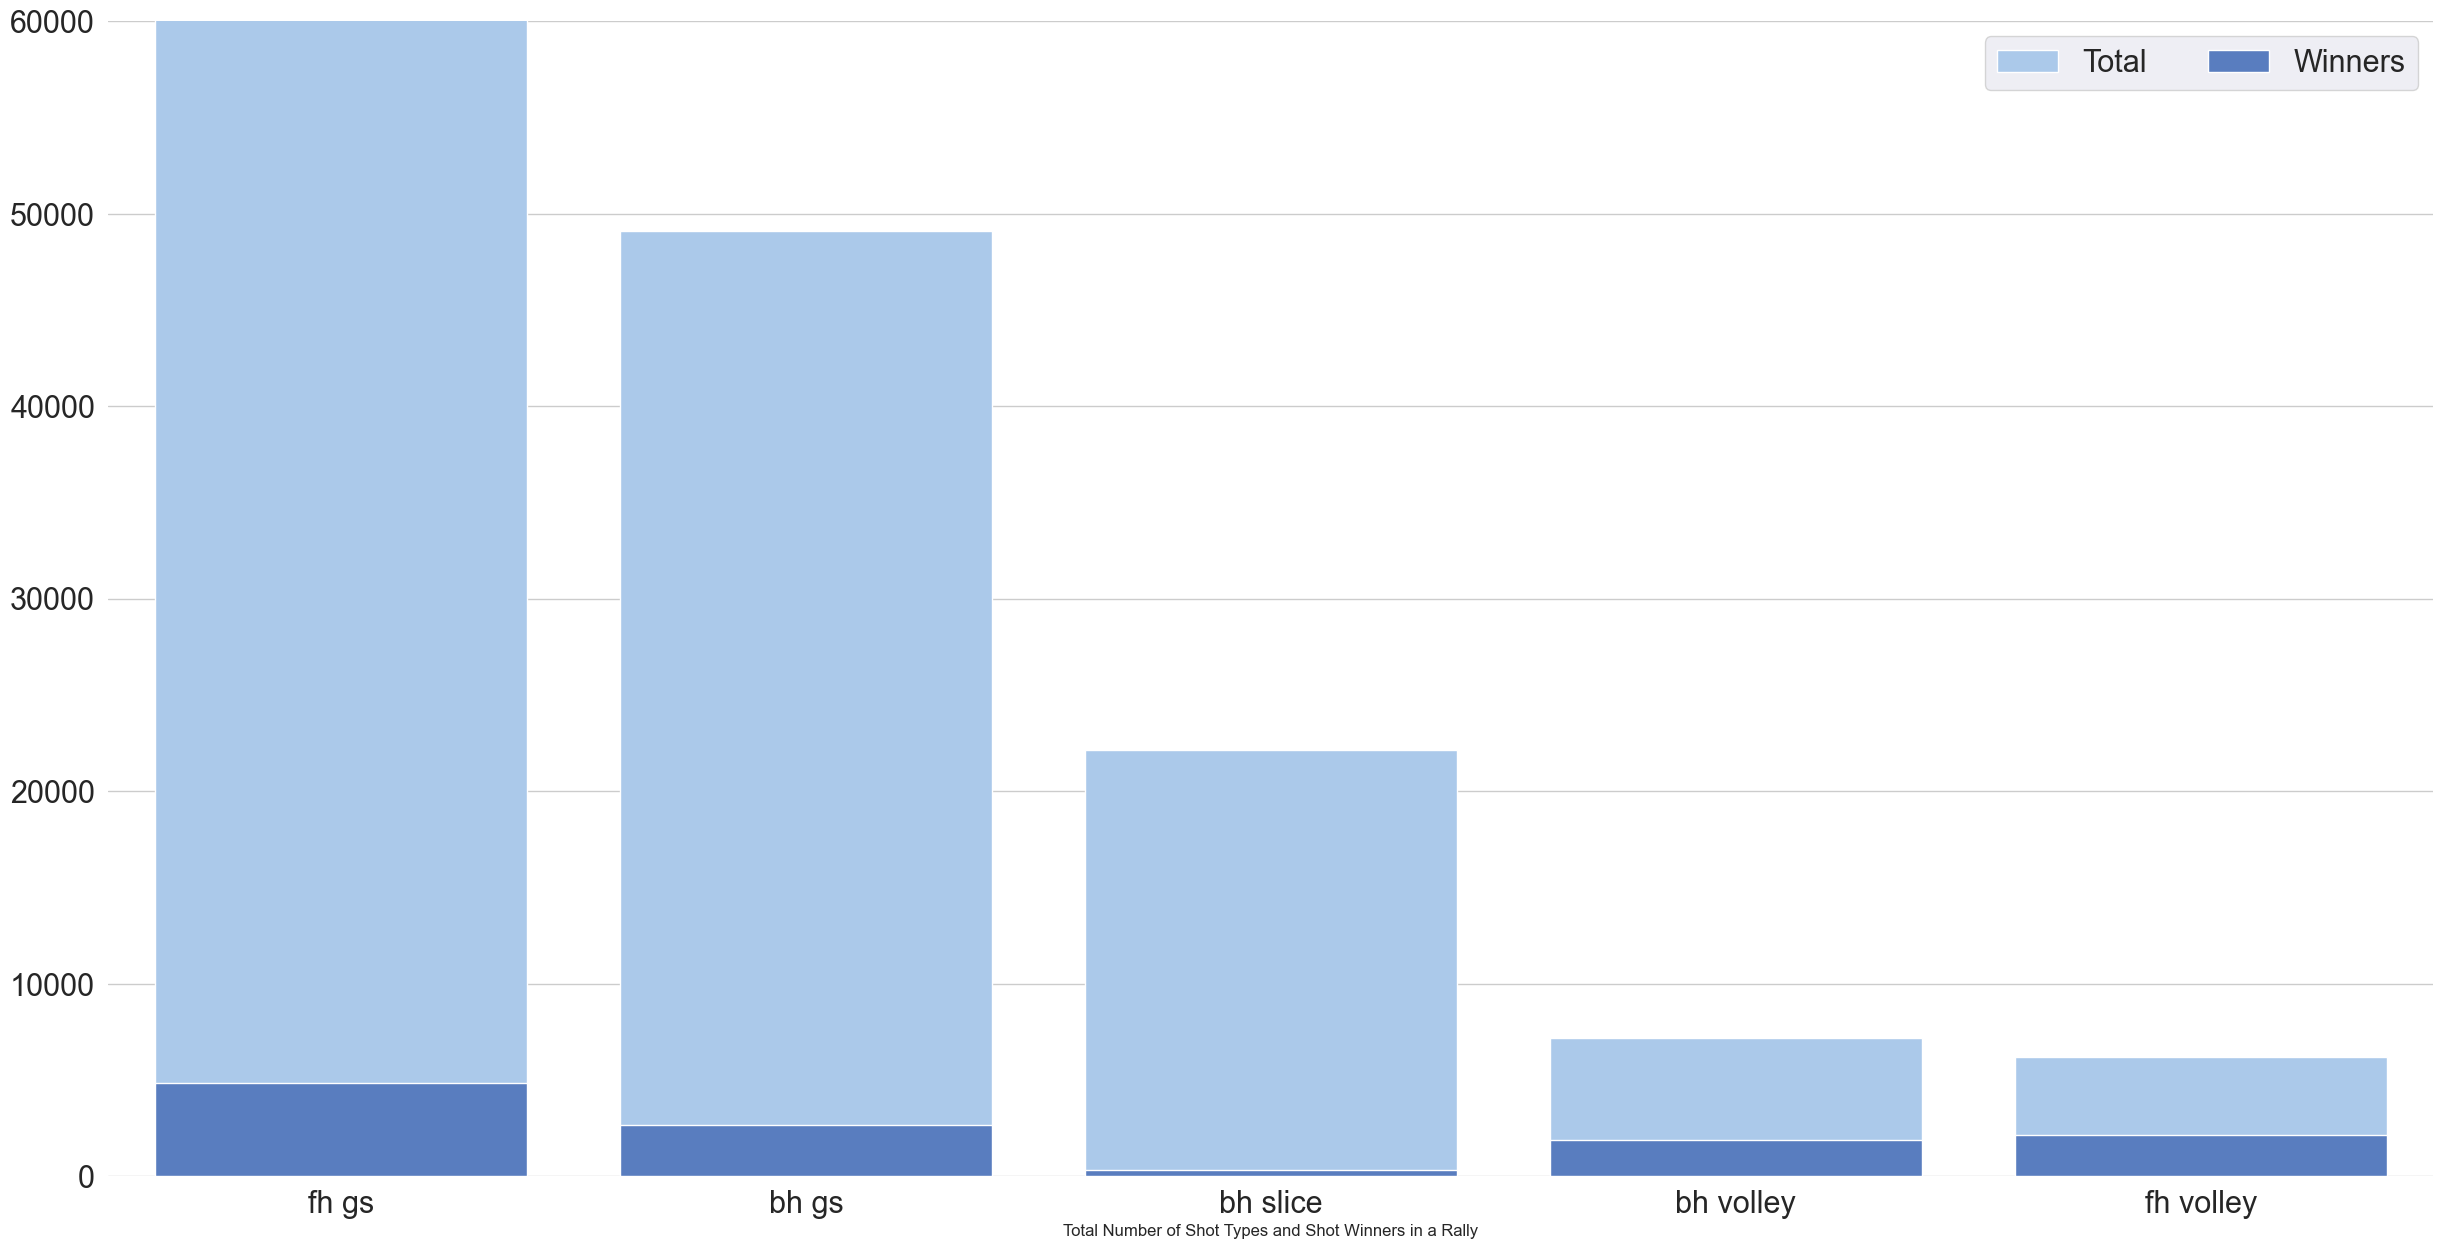

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 15))

sns.set(font_scale=2)
sns.set_color_codes("pastel")
sns.barplot(x="shot", y="total", data=shot_selection_df,
            label="Total", color="b")


sns.set_color_codes("muted")
sns.barplot(x="shot", y="winners", data=shot_selection_df,
            label="Winners", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylim=(0, 60000), ylabel="",
       xlabel="Total Number of Shot Types and Shot Winners in a Rally")

# get label text
_, xlabels = plt.xticks()

# set the x-labels with
ax.set_xticklabels(xlabels, size=22)

# get label text
_, ylabels = plt.yticks()

# set the y-labels with
ax.set_yticklabels(ylabels, size=22)

sns.despine(left=True, bottom=True)

In [23]:
f.savefig("shot_fig.png")

#### flipped

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/597388156.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, size=30)


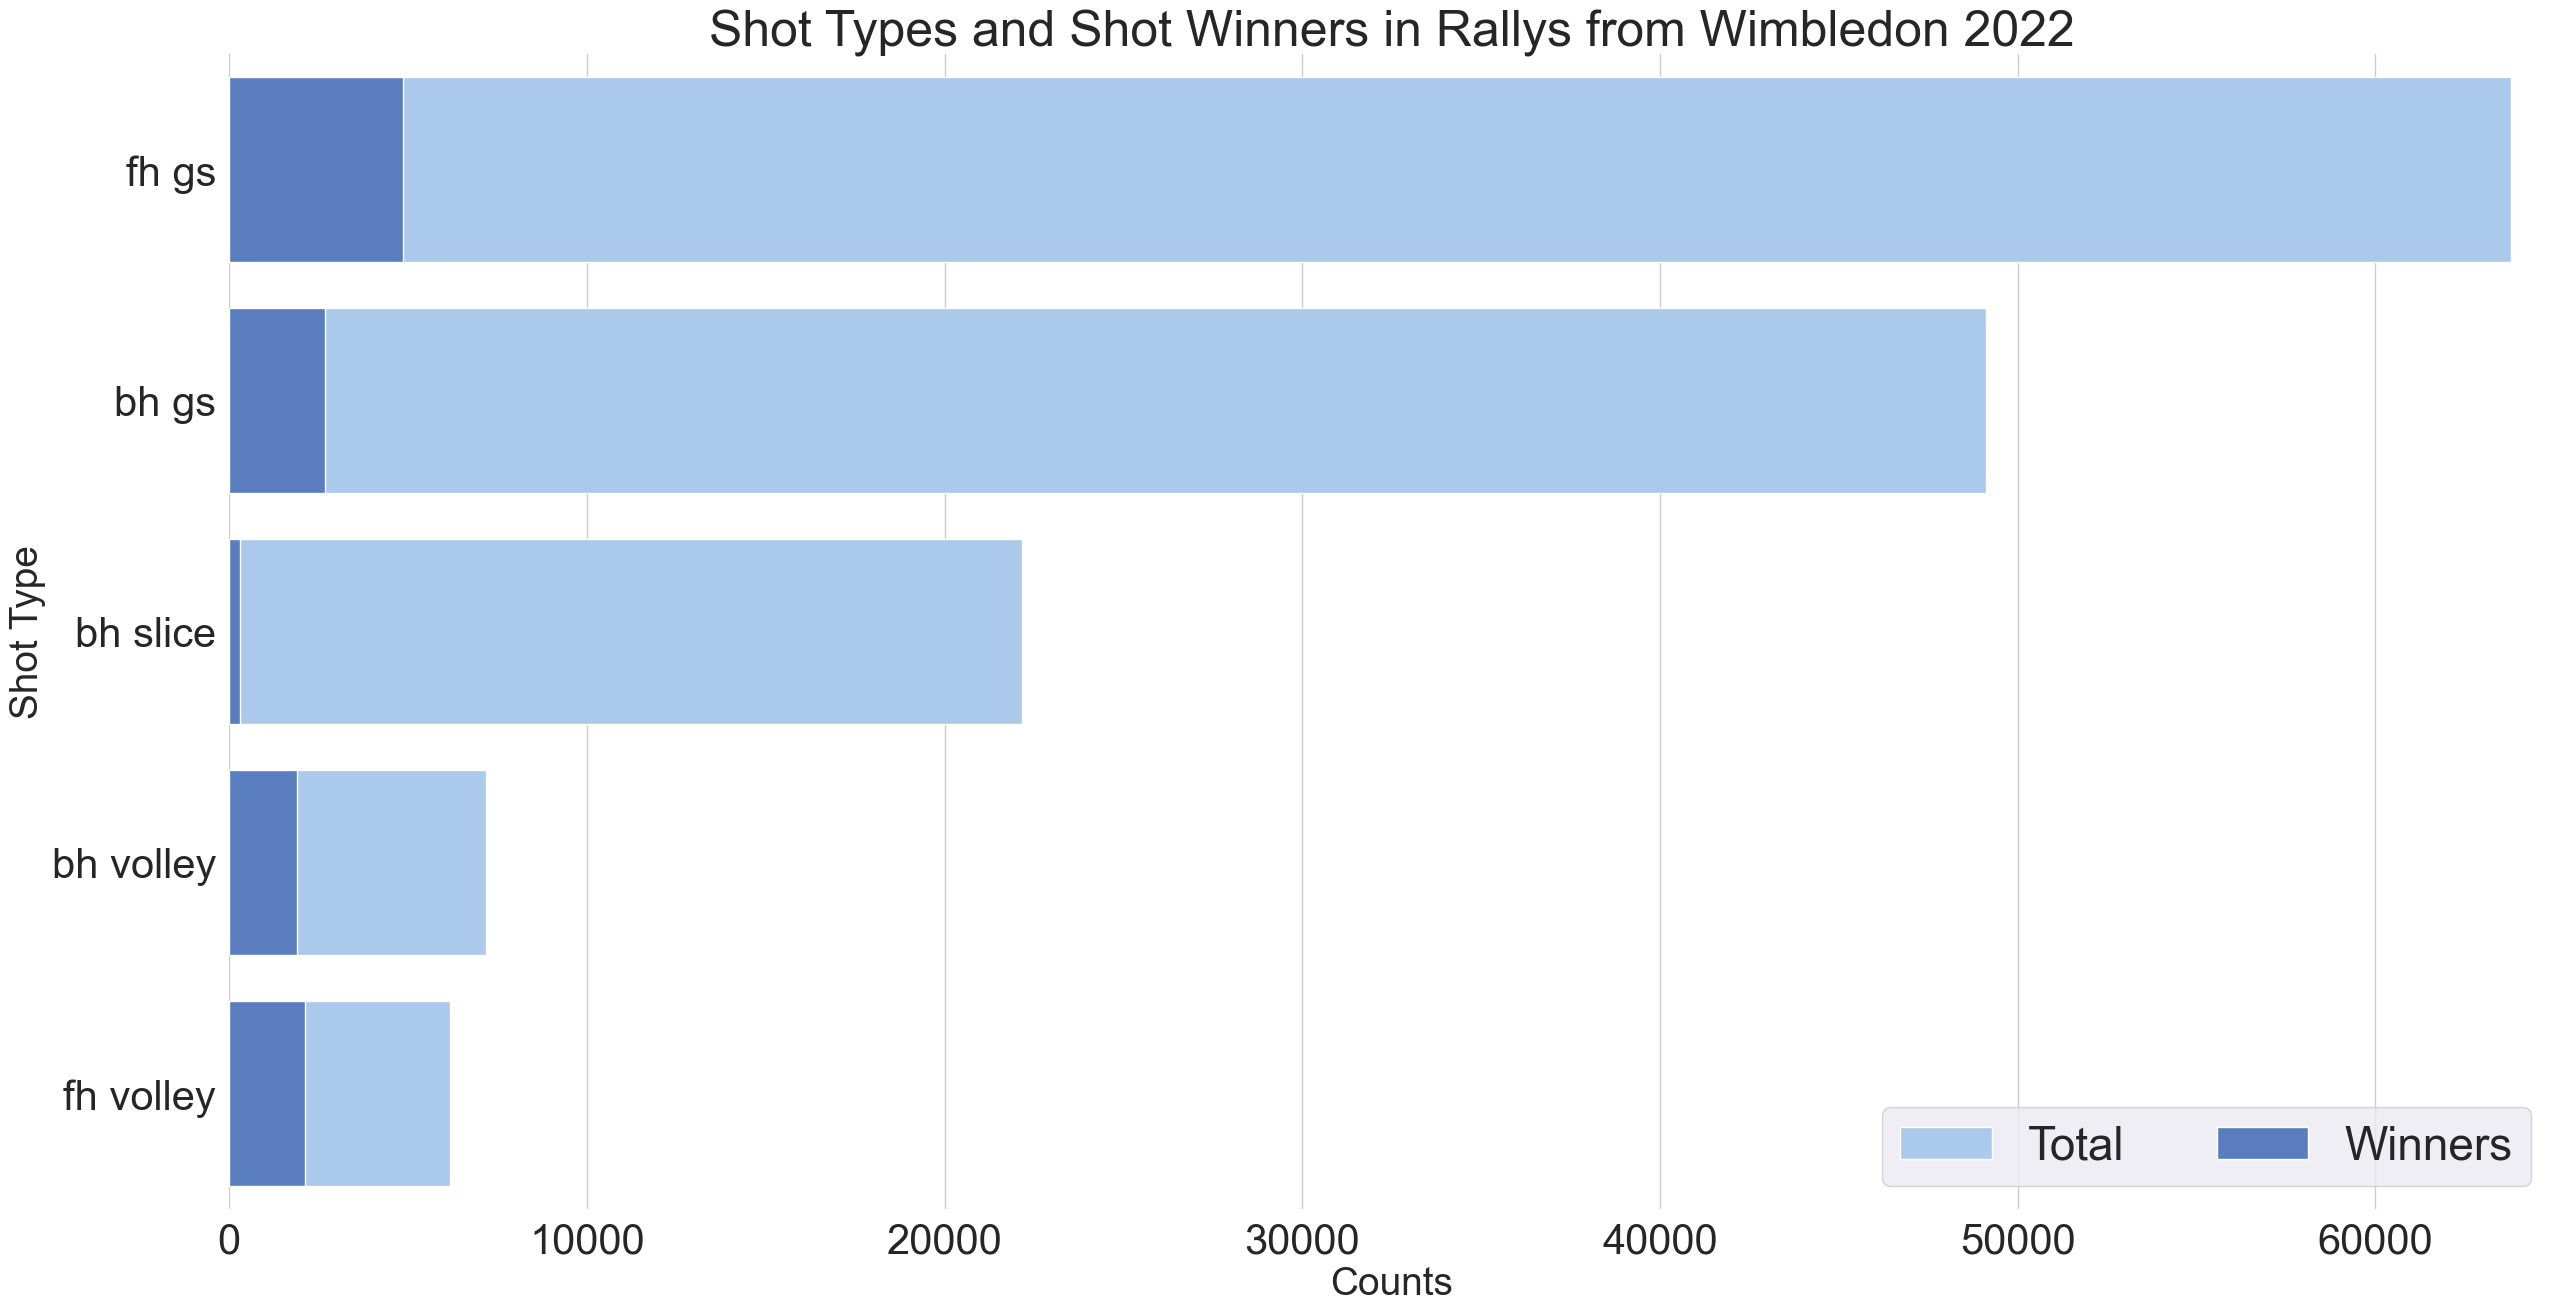

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

plt.rcParams["axes.labelsize"] = 28
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 15))

sns.set(font_scale=3)
sns.set_color_codes("pastel")
sns.barplot(x="total", y="shot", data=shot_selection_df,
            label="Total", color="b").set_title('Shot Types and Shot Winners in Rallys from Wimbledon 2022')


sns.set_color_codes("muted")
sns.barplot(x="winners", y="shot", data=shot_selection_df,
            label="Winners", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 65000), ylabel="Shot Type",
       xlabel="Counts")

# get label text
_, xlabels = plt.xticks()

# set the x-labels with
ax.set_xticklabels(xlabels, size=30)

# get label text
_, ylabels = plt.yticks()

# set the y-labels with
ax.set_yticklabels(ylabels, size=30)

sns.despine(left=True, bottom=True)

In [25]:
f.savefig("shot_fig_flipped.png")

### Percentages

In [26]:
shot_selection_df['winner_percentage'] = shot_selection_df['winners']/shot_selection_df['total']

In [27]:
shot_selection_df.sort_values("winners", ascending=False)

,shot,total,winners,winner_percentage
0,fh gs,63776,4865,0.076283
1,bh gs,49124,2681,0.054576
4,fh volley,6178,2122,0.343477
5,bh volley,7183,1896,0.263957
3,bh slice,22149,311,0.014041


In [28]:
shot_selection_df.sort_values("total", ascending=False)

,shot,total,winners,winner_percentage
0,fh gs,63776,4865,0.076283
1,bh gs,49124,2681,0.054576
3,bh slice,22149,311,0.014041
5,bh volley,7183,1896,0.263957
4,fh volley,6178,2122,0.343477


In [29]:
shot_selection_df.sort_values("winner_percentage", ascending=False)

,shot,total,winners,winner_percentage
4,fh volley,6178,2122,0.343477
5,bh volley,7183,1896,0.263957
0,fh gs,63776,4865,0.076283
1,bh gs,49124,2681,0.054576
3,bh slice,22149,311,0.014041


## Last 2 shots

In [30]:
shot_map

{'f': [4865, 63776, 'fh gs'],
 'b': [2681, 49124, 'bh gs'],
 'r': [91, 4477, 'fh slice'],
 's': [311, 22149, 'bh slice'],
 'v': [2122, 6178, 'fh volley'],
 'z': [1896, 7183, 'bh volley'],
 'o': [1221, 1978, 'oh smash'],
 'p': [61, 212, 'bh smash'],
 'u': [165, 667, 'fh drop'],
 'y': [138, 889, 'bh drop'],
 'l': [93, 1124, 'fh lob'],
 'm': [111, 2260, 'bh lob'],
 'h': [81, 1116, 'fh hv'],
 'i': [65, 1236, 'bh hv'],
 'j': [139, 302, 'fh sv'],
 'k': [29, 71, 'bh sv'],
 't': [2, 99, 'trickshot'],
 'q': [10, 134, 'unknown'],
 'c': [244, 2916, 'challenge']}

In [31]:
shot_regex = '[fbrsvzopuylmhijktqc]'
shot_and_direction = '[fbrsvzopuylmhijktqc][123]'

In [32]:
match = re.findall(shot_regex, '6+s28z2m1o3*', flags=0)

In [33]:
match

['s', 'z', 'm', 'o']

In [34]:
match[-2]

'm'

In [35]:
winning_sequence = []
for rally in winning_shots:
    shots = re.findall(shot_and_direction, rally, flags=0)
    if len(shots) > 2:
        winning_sequence.append({
            'rally': rally,
            'receiving_shot': shots[-2],
            'winning_shot': shots[-1], 
            'combined': shots[-2] + shots[-1]
        })

In [36]:
winning_sequence_df = pd.DataFrame(winning_sequence)

In [37]:
# rallys of length greater than two
winning_sequence_df

,rally,receiving_shot,winning_shot,combined
0,6f2f2b2b3*,b2,b3,b2b3
1,4b2f3s2f+2b2v1f1*,v1,f1,v1f1
2,6s2f+3s2o1*,s2,o1,s2o1
3,5f2f3s3f3s2f1f2f2b2b3s1f2f1f1f3*,f1,f3,f1f3
4,5b2f3b2f1f3b2f3*,b2,f3,b2f3
...,...,...,...,...
7480,4+s17z1m2o1*,m2,o1,m2o1
7481,4+s17z3f3*,z3,f3,z3f3
7482,5+f17z1b3v3*,b3,v3,b3v3
7483,6+s28z2m1o3*,m1,o3,m1o3


In [38]:
winning_sequence_counts = pd.DataFrame(winning_sequence_df['combined'].value_counts())

In [39]:
winning_sequence_counts_top_ten = winning_sequence_counts.head(10)

In [40]:
winning_sequence_counts_top_ten['percentage of total winners'] = winning_sequence_counts_top_ten['combined'] / winning_sequence_df.shape[0] 

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/1416413489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_sequence_counts_top_ten['percentage of total winners'] = winning_sequence_counts_top_ten['combined'] / winning_sequence_df.shape[0]


In [41]:
winning_sequence_counts_top_ten

,combined,percentage of total winners
f1f3,197,0.026319
m2o1,197,0.026319
m2o3,162,0.021643
b1v1,152,0.020307
f1f1,135,0.018036
b2v1,117,0.015631
b3z1,110,0.014696
b2f1,108,0.014429
f3b1,107,0.014295
f3z3,104,0.013894


## P(shot is winner | receiving shot)

Getting all probabilities for each shot pair with direction

### Charting Definitions

```
{
    'f': 'fh gs,
     'b': 'bh gs',
     'r': 'fh slice',
     's': 'bh slice',
     'v': 'fh volley',
     'z': 'bh volley',
     'o': 'over hand smash',
     'p': 'bh smash',
     'u': 'fh drop',
     'y': 'bh drop',
     'l': 'fh lob',
     'm': 'bh lob',
     'h': 'fh half volley',
     'i': 'bh half volley',
     'j': 'fh swinging volley',
     'k': 'bh swinging volley',
     't': 'trickshot',
     'q': 'unknown',
     'c': 'challenge'
}
 ```
 
``` 
{ 
    '1': 'to a right-hander's forehand side / left-hander's backhand side',
    '2': 'down the middle of the court',
    '3': 'to a right-hander's backhand side / left-hander's forehand side'
}
```

### Examples

##### f1 = forehand to a (righty's) forehand side; this is the typical crosscourt forehand

##### b3s3b1f1v2 = (assuming both players are righties) backhand crosscourt, backhand slice crosscourt, backhand down the line, forehand crosscourt, volley down the middle.

In [42]:
rallys

435                                  4f1*
436       6f2f3b3b2f2f2f2b2b3b2b3b2f1f1w@
437                             4r2f+2b3*
438                                    6n
439                                    5#
                       ...               
619387                 6+f28v3l3l2o=1b1n@
619388                           4+f28z3*
619391                          6+b27h1d#
619394                              4f37*
619395                             6+f18*
Length: 78705, dtype: object

In [43]:
winning_shots

435                   4f1*
437              4r2f+2b3*
442             6f2f2b2b3*
444                     4*
445                     6*
                ...       
619371        6+s28z2m1o3*
619374    4+s27v3l2o1m1o3*
619388            4+f28z3*
619394               4f37*
619395              6+f18*
Length: 20290, dtype: object

In [44]:
shot_regex = '[fbrsvzopuylmhijktqc]'
shot_and_direction = '[fbrsvzopuylmhijktqc][123]'
shot_and_direction_new = '[fbrsvzopuylmhijktqc][123]|[fbrsvzopuylmhijktqc][\^+=;-][123]|[fbrsvzopuylmhijktqc][\^+=;-][\^+=;-][123]'

In [45]:
shots = re.findall(shot_and_direction_new, '6r28f+1l1o=1r2f+;3m+1f2v^1f-1*', flags=0)

In [46]:
sequence = []
for rally in rallys:
    shots = re.findall(shot_and_direction_new, rally, flags=0)
    is_winner = 0
    is_forced_error = 0
    is_winner_or_forced_error = 0
    
    if len(shots) > 2:
        if '*' in rally:
            is_winner = 1
            is_winner_or_forced_error = 1
        if '#' in rally:
            is_forced_error = 1
            is_winner_or_forced_error = 1
        sequence.append({
            'rally': rally,
            'receiving_shot': shots[-2],
            'returned_shot': shots[-1], 
            'combined': shots[-2] + shots[-1],
            'is_winner': is_winner,
            'is_forced_error': is_forced_error,
            'is_winner_or_forced_error': is_winner_or_forced_error
        })

In [47]:
sequence_df = pd.DataFrame(sequence)

In [48]:
sequence_df.to_csv('data/results/sequence_df.csv')

## Results

Data includes all rally's and whether or not it is a winner or a forced error. This also gives us the last sequence of shots (receiving and returned shots)

In [49]:
sequence_df

,rally,receiving_shot,returned_shot,combined,is_winner,is_forced_error,is_winner_or_forced_error
0,6f2f3b3b2f2f2f2b2b3b2b3b2f1f1w@,f1,f1,f1f1,0,0,0
1,4r2f+2b3*,f+2,b3,f+2b3,1,0,1
2,6f2r2f2b2b1w@,b2,b1,b2b1,0,0,0
3,6b2b2b2b2b2f2b;2b2s3f1f2d@,f1,f2,f1f2,0,0,0
4,6f2f2b2b3*,b2,b3,b2b3,1,0,1
...,...,...,...,...,...,...,...
22917,6+s28z2m1o3*,m1,o3,m1o3,1,0,1
22918,4+s27v3l2o1m1o3*,m1,o3,m1o3,1,0,1
22919,4+f27b2b1z2n#,b1,z2,b1z2,0,1,1
22920,4+s17z3l1o1s1s+1m1d@,s+1,m1,s+1m1,0,0,0


## Statistics and Analysis

For every last 2 shot combination, we'll need to find **P(A is a winner | B is receiving shot)**

In [50]:
value_counts_dict = sequence_df['combined'].value_counts().to_dict()

In [51]:
len(value_counts_dict)

2378

In [52]:
total_winners_or_forced_errors_df = sequence_df.groupby('combined')['is_winner_or_forced_error'].sum()

In [53]:
total_winners_or_forced_errors_df

combined
b+1b1      6
b+1b2      1
b+1b3      7
b+1b;1     1
b+1f1     36
          ..
z^3s-3     8
z^3s1      7
z^3s2      1
z^3s3      3
z^3y-3     1
Name: is_winner_or_forced_error, Length: 2378, dtype: int64

In [54]:
stats_list = []

for key, value in value_counts_dict.items():
    stats_dict = {
        'combined': key,
        'total_occurrences': value,
        'num_of_winners_or_forced_errors': total_winners_or_forced_errors_df[key]
    }
    stats_list.append(stats_dict)

In [55]:
stats_df = pd.DataFrame(stats_list)

In [56]:
stats_df['percentage_of_winner'] = stats_df['num_of_winners_or_forced_errors'] / stats_df['total_occurrences']

In [57]:
stats_df['percentage_of_total_occurences_of_combination'] = stats_df['total_occurrences'] / stats_df['total_occurrences'].sum()

In [58]:
stats_df['percentage_of_overall_winner'] = stats_df['num_of_winners_or_forced_errors'] / stats_df['total_occurrences'].sum()

In [160]:
stats_df.head(10)

,combined,total_occurrences,num_of_winners_or_forced_errors,percentage_of_winner,percentage_of_total_occurences_of_combination,percentage_of_overall_winner
0,f1f1,801,426,0.531835,0.034945,0.018585
1,f1f3,776,448,0.577320,0.033854,0.019545
2,f3b3,456,188,0.412281,0.019894,0.008202
3,f3b1,378,174,0.460317,0.016491,0.007591
4,b3b1,340,140,0.411765,0.014833,0.006108
5,b2f1,310,122,0.393548,0.013524,0.005322
6,f1f2,296,143,0.483108,0.012913,0.006239
7,b3b3,290,78,0.268966,0.012652,0.003403
8,f2f3,279,110,0.394265,0.012172,0.004799
9,b1f1,274,160,0.583942,0.011954,0.006980


In [60]:
stats_df.sort_values('total_occurrences', ascending=False).to_csv('data/results/stats_df.csv')

# Modelling

## Logistic Regression


In [61]:
wimbeldon_chart_df

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
435,20220706-M-Wimbledon-QF-Nick_Kyrgios-Cristian_...,1,0,0,0.0,0.0,0-0,1 (1),1,0,...,NaN,False,False,True,False,False,False,2,0,2
436,20220706-M-Wimbledon-QF-Nick_Kyrgios-Cristian_...,2,0,0,0.0,0.0,0-15,1 (2),1,0,...,NaN,False,False,False,False,True,False,2,0,14
437,20220706-M-Wimbledon-QF-Nick_Kyrgios-Cristian_...,3,0,0,0.0,0.0,0-30,1 (3),1,0,...,NaN,False,False,True,False,False,False,2,0,4
438,20220706-M-Wimbledon-QF-Nick_Kyrgios-Cristian_...,4,0,0,0.0,0.0,0-40,1 (4),1,0,...,1.0,False,False,False,False,True,False,2,0,4
439,20220706-M-Wimbledon-QF-Nick_Kyrgios-Cristian_...,5,0,0,0.0,1.0,0-0,2 (1),1,0,...,NaN,False,True,False,False,False,False,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619391,19600704-M-Wimbledon-F-Rod_Laver-Neale_Fraser,284,1,2,5.0,6.0,AD-40,47 (8),0,0,...,1.0,False,False,False,True,False,False,2,0,2
619392,19600704-M-Wimbledon-F-Rod_Laver-Neale_Fraser,285,1,2,5.0,6.0,40-40,47 (9),0,0,...,NaN,False,False,False,True,False,False,2,0,4
619393,19600704-M-Wimbledon-F-Rod_Laver-Neale_Fraser,286,1,2,5.0,6.0,40-AD,47 (10),0,0,...,NaN,False,False,True,False,False,False,1,1,9
619394,19600704-M-Wimbledon-F-Rod_Laver-Neale_Fraser,287,1,2,5.0,6.0,40-40,47 (11),0,0,...,1.0,False,False,True,False,False,False,2,0,2


### Preprocessing

Sequences ending with **@** or **#** indicate an error. The shot that leads to the error is 1 shots beforehand in the rally data.

Sequences ending with **\*** indicate a winner. The shot that is the winner is the shot attached to the *

**1.** We'll need to get the game winners added to the actual rows of the points in order to construct our trainning data

**2.** Create our features

**3.** Split data into train and test

In [62]:
wimbeldon_chart_df['match_id'].unique()

array(['20220706-M-Wimbledon-QF-Nick_Kyrgios-Cristian_Garin',
       '20220704-M-Wimbledon-R16-Rafael_Nadal-Botic_Van_De_Zandschulp',
       '20220703-M-Wimbledon-R16-Novak_Djokovic-Tim_Van_Rijthoven',
       '20220702-M-Wimbledon-R32-Stefanos_Tsitsipas-Nick_Kyrgios',
       '20220630-M-Wimbledon-R64-Nick_Kyrgios-Filip_Krajinovic',
       '20220628-M-Wimbledon-R128-Feliciano_Lopez-Botic_Van_De_Zandschulp',
       '20220627-M-Wimbledon-R128-Federico_Delbonis-Tim_Van_Rijthoven',
       '20210711-M-Wimbledon-F-Novak_Djokovic-Matteo_Berrettini',
       '20210709-M-Wimbledon-SF-Novak_Djokovic-Denis_Shapovalov',
       '20210709-M-Wimbledon-SF-Hubert_Hurkacz-Matteo_Berrettini',
       '20210707-M-Wimbledon-QF-Novak_Djokovic-Marton_Fucsovics',
       '20210707-M-Wimbledon-QF-Felix_Auger_Aliassime-Matteo_Berrettini',
       '20210705-M-Wimbledon-R16-Lorenzo_Sonego-Roger_Federer',
       '20210703-M-Wimbledon-R32-Cameron_Norrie-Roger_Federer',
       '20210701-M-Wimbledon-R64-Richard_Gasquet-Ro

In [63]:
shot_and_direction_new

'[fbrsvzopuylmhijktqc][123]|[fbrsvzopuylmhijktqc][\\^+=;-][123]|[fbrsvzopuylmhijktqc][\\^+=;-][\\^+=;-][123]'

In [64]:
shots = re.findall(shot_and_direction_new, '5b28f37s29f3d@', flags=0)

In [65]:
shots

['b2', 'f3', 's2', 'f3']

### Winners of each game

In [66]:
def get_game_winners(df_test):
    winner_of_game = []
    count = 0 
    state_of_games = [0,0]
    state_of_sets = [0,0]
    len_of_match = len(df_test)
    i = 1 
    total = 0 
    for set1, set2, pts, gm1, gm2, pt_winner in zip(df_test['Set1'], df_test['Set2'], df_test['Pts'], df_test['Gm1'], df_test['Gm2'], df_test['PtWinner']):
        if pts == '0-0' and (set1 > state_of_sets[0] or set2 > state_of_sets[1]):
            if set1 > state_of_sets[0]:
                winner_of_game.extend([1] * count)
            if set2 > state_of_sets[1]:
                winner_of_game.extend([2] * count)
            if i == len_of_match:
                winner_of_game.append(-1)

            #print(set1, set2, count)
            total += count
            state_of_sets = [set1, set2]
            state_of_games = [0,0]
            count = 1
            i += 1
            continue

        if pts == '0-0' and gm1+gm2 > 0:
            if gm1 > state_of_games[0]:
                winner_of_game.extend([1] * count)
            if gm2 > state_of_games[1]:
                winner_of_game.extend([2] * count)
            #print(gm1, gm2, count)
            total += count

            state_of_games = [gm1, gm2]
            count = 1
            i += 1
            continue

        if i == len_of_match:
            count += 1
            #print("THE END", count)
            total += count
            if pt_winner == 1:
                winner_of_game.extend([1] * count)
            else:
                winner_of_game.extend([2] * count)
            break
        i += 1
        count += 1
        
    df_test['winner_of_game'] = winner_of_game
    return df_test

In [67]:
match_dfs = []
ignore = ['19990704-M-Wimbledon-F-Pete_Sampras-Andre_Agassi', '19920705-M-Wimbledon-F-Andre_Agassi-Goran_Ivanisevic', '19930704-M-Wimbledon-F-Jim_Courier-Pete_Sampras']
for match_id in wimbeldon_chart_df['match_id'].unique():
    if match_id not in ignore:
        print(match_id)
        match_dfs.append(get_game_winners(wimbeldon_chart_df[wimbeldon_chart_df['match_id'] == match_id]))

20220706-M-Wimbledon-QF-Nick_Kyrgios-Cristian_Garin
20220704-M-Wimbledon-R16-Rafael_Nadal-Botic_Van_De_Zandschulp
20220703-M-Wimbledon-R16-Novak_Djokovic-Tim_Van_Rijthoven
20220702-M-Wimbledon-R32-Stefanos_Tsitsipas-Nick_Kyrgios
20220630-M-Wimbledon-R64-Nick_Kyrgios-Filip_Krajinovic
20220628-M-Wimbledon-R128-Feliciano_Lopez-Botic_Van_De_Zandschulp
20220627-M-Wimbledon-R128-Federico_Delbonis-Tim_Van_Rijthoven
20210711-M-Wimbledon-F-Novak_Djokovic-Matteo_Berrettini
20210709-M-Wimbledon-SF-Novak_Djokovic-Denis_Shapovalov
20210709-M-Wimbledon-SF-Hubert_Hurkacz-Matteo_Berrettini
20210707-M-Wimbledon-QF-Novak_Djokovic-Marton_Fucsovics
20210707-M-Wimbledon-QF-Felix_Auger_Aliassime-Matteo_Berrettini
20210705-M-Wimbledon-R16-Lorenzo_Sonego-Roger_Federer
20210703-M-Wimbledon-R32-Cameron_Norrie-Roger_Federer
20210701-M-Wimbledon-R64-Richard_Gasquet-Roger_Federer
20210701-M-Wimbledon-R64-Matteo_Berrettini-Botic_Van_De_Zandschulp
20210701-M-Wimbledon-R64-Daniil_Medvedev-Carlos_Alcaraz
20210701-M-Wi

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

20190705-M-Wimbledon-R32-Daniil_Medvedev-David_Goffin
20190704-M-Wimbledon-R64-Roger_Federer-Jay_Clarke
20190704-M-Wimbledon-R64-Rafael_Nadal-Nick_Kyrgios
20190704-M-Wimbledon-R64-Matteo_Berrettini-Marcos_Baghdatis
20190704-M-Wimbledon-R64-Cameron_Norrie-Kei_Nishikori
20190703-M-Wimbledon-R64-Thomas_Fabbiano-Ivo_Karlovic
20190703-M-Wimbledon-R64-Stan_Wawrinka-Reilly_Opelka
20190703-M-Wimbledon-R64-Novak_Djokovic-Denis_Kudla
20190703-M-Wimbledon-R64-Milos_Raonic-Robin_Haase
20190702-M-Wimbledon-R128-Thiago_Monteiro-Kei_Nishikori
20190702-M-Wimbledon-R128-Sam_Querrey-Dominic_Thiem
20190702-M-Wimbledon-R128-Lucas_Pouille-Richard_Gasquet
20190702-M-Wimbledon-R128-Brayden_Schnur-Marcos_Baghdatis
20190701-M-Wimbledon-R128-Stefanos_Tsitsipas-Thomas_Fabbiano
20190701-M-Wimbledon-R128-Stan_Wawrinka-Ruben_Bemelmans
20190701-M-Wimbledon-R128-Rafael_Nadal-Yuichi_Sugita
20190701-M-Wimbledon-R128-Novak_Djokovic-Philipp_Kohlschreiber
20190701-M-Wimbledon-R128-Jozef_Kovalik-Robin_Haase
20190701-M-Wimb

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

20160629-M-Wimbledon-R64-Roger_Federer-Marcus_Willis
20150712-M-Wimbledon-F-Roger_Federer-Novak_Djokovic
20150710-M-Wimbledon-SF-Roger_Federer-Andy_Murray
20150710-M-Wimbledon-SF-Novak_Djokovic-Richard_Gasquet
20150709-M-Wimbledon-QF-Marin_Cilic-Novak_Djokovic
20150708-M-Wimbledon-QF-Stan_Wawrinka-Richard_Gasquet
20150708-M-Wimbledon-QF-Roger_Federer-Gilles_Simon
20150706-M-Wimbledon-R16-Andy_Murray-Ivo_Karlovic
20150704-M-Wimbledon-R32-Samuel_Groth-Roger_Federer
20150702-M-Wimbledon-R64-Sam_Querrey-Roger_Federer
20150702-M-Wimbledon-R64-Dustin_Brown-Rafael_Nadal
20150630-M-Wimbledon-R128-Roger_Federer-Damir_Dzumhur
20140706-M-Wimbledon-F-Novak_Djokovic-Roger_Federer
20140704-M-Wimbledon-SF-Milos_Raonic-Roger_Federer
20140704-M-Wimbledon-SF-Grigor_Dimitrov-Novak_Djokovic
20140702-M-Wimbledon-QF-Grigor_Dimitrov-Andy_Murray
20140701-M-Wimbledon-R16-Nick_Kyrgios-Rafael_Nadal
20140628-M-Wimbledon-R32-Mikhail_Kukushkin-Rafael_Nadal
20140627-M-Wimbledon-R32-Grigor_Dimitrov-Alexandr_Dolgopolo

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

20140625-M-Wimbledon-R64-Tomas_Berdych-Bernard_Tomic
20130707-M-Wimbledon-F-Novak_Djokovic-Andy_Murray
20130705-M-Wimbledon-SF-Novak_Djokovic-Juan_Martin_Del_Potro
20130705-M-Wimbledon-SF-Andy_Murray-Jerzy_Janowicz
20130703-M-Wimbledon-QF-David_Ferrer-Juan_Martin_Del_Potro
20130626-M-Wimbledon-R64-Roger_Federer-Sergiy_Stakhovsky
20120708-M-Wimbledon-F-Roger_Federer-Andy_Murray
20120706-M-Wimbledon-SF-Roger_Federer-Novak_Djokovic
20120706-M-Wimbledon-SF-Andy_Murray-Jo_Wilfried_Tsonga
20120628-M-Wimbledon-R64-Lukas_Rosol-Rafael_Nadal
20110703-M-Wimbledon-F-Novak_Djokovic-Rafael_Nadal
20110701-M-Wimbledon-SF-Novak_Djokovic-Jo_Wilfried_Tsonga
20110701-M-Wimbledon-SF-Andy_Murray-Rafael_Nadal
20110629-M-Wimbledon-QF-Roger_Federer-Jo_Wilfried_Tsonga
20100704-M-Wimbledon-F-Tomas_Berdych-Rafael_Nadal
20100702-M-Wimbledon-SF-Tomas_Berdych-Novak_Djokovic
20100702-M-Wimbledon-SF-Andy_Murray-Rafael_Nadal
20100630-M-Wimbledon-QF-Roger_Federer-Tomas_Berdych
20100622-M-Wimbledon-R128-Nicolas_Mahut-Joh

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

20060709-M-Wimbledon-F-Roger_Federer-Rafael_Nadal
20060707-M-Wimbledon-SF-Marcos_Baghdatis-Rafael_Nadal
20060707-M-Wimbledon-SF-Jonas_Bjorkman-Roger_Federer
20060705-M-Wimbledon-QF-Mario_Ancic-Roger_Federer
20060701-M-Wimbledon-R32-Rafael_Nadal-Andre_Agassi
20060627-M-Wimbledon-R128-Roger_Federer-Richard_Gasquet
20050703-M-Wimbledon-F-Roger_Federer-Andy_Roddick
20050701-M-Wimbledon-SF-Roger_Federer-Lleyton_Hewitt
20050701-M-Wimbledon-SF-Andy_Roddick-Thomas_Johansson
20050629-M-Wimbledon-QF-Roger_Federer-Fernando_Gonzalez
20050629-M-Wimbledon-QF-Lleyton_Hewitt-Feliciano_Lopez
20050623-M-Wimbledon-R64-Gilles_Muller-Rafael_Nadal
20050621-M-Wimbledon-R128-George_Bastl-Andy_Murray
20040704-M-Wimbledon-F-Roger_Federer-Andy_Roddick
20040703-M-Wimbledon-SF-Sebastien_Grosjean-Roger_Federer
20040703-M-Wimbledon-SF-Mario_Ancic-Andy_Roddick
20040630-M-Wimbledon-QF-Roger_Federer-Lleyton_Hewitt
20040628-M-Wimbledon-R16-Lleyton_Hewitt-Carlos_Moya
20030706-M-Wimbledon-F-Roger_Federer-Mark_Philippoussi

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

19990602-M-Wimbledon-SF-Patrick_Rafter-Andre_Agassi
19980705-M-Wimbledon-F-Goran_Ivanisevic-Pete_Sampras
19980704-M-Wimbledon-SF-Goran_Ivanisevic-Richard_Krajicek
19980622-M-Wimbledon-SF-Tim_Henman-Pete_Sampras
19970706-M-Wimbledon-F-Cedric_Pioline-Pete_Sampras
19970704-M-Wimbledon-SF-Pete_Sampras-Todd_Woodbridge
19970704-M-Wimbledon-SF-Michael_Stich-Cedric_Pioline
19960707-M-Wimbledon-F-Richard_Krajicek-Malivai_Washington
19960706-M-Wimbledon-SF-Todd_Martin-Malivai_Washington
19960706-M-Wimbledon-SF-Richard_Krajicek-Jason_Stoltenberg
19950709-M-Wimbledon-F-Pete_Sampras-Boris_Becker
19950708-M-Wimbledon-SF-Pete_Sampras-Goran_Ivanisevic
19950707-M-Wimbledon-SF-Boris_Becker-Andre_Agassi
19940703-M-Wimbledon-F-Pete_Sampras-Goran_Ivanisevic
19940702-M-Wimbledon-SF-Todd_Martin-Pete_Sampras
19940702-M-Wimbledon-SF-Goran_Ivanisevic-Boris_Becker
19940623-M-Wimbledon-R64-Stefan_Edberg-Kenneth_Carlsen
19930703-M-Wimbledon-SF-Pete_Sampras-Boris_Becker
19930702-M-Wimbledon-SF-Jim_Courier-Stefan_Ed

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

19910706-M-Wimbledon-SF-David_Wheaton-Boris_Becker
19910624-M-Wimbledon-R128-Marc_Rosset-Stefan_Edberg
19900708-M-Wimbledon-F-Boris_Becker-Stefan_Edberg
19900707-M-Wimbledon-SF-Stefan_Edberg-Ivan_Lendl
19900706-M-Wimbledon-SF-Boris_Becker-Goran_Ivanisevic
19890709-M-Wimbledon-F-Boris_Becker-Stefan_Edberg
19890708-M-Wimbledon-SF-Ivan_Lendl-Boris_Becker
19890706-M-Wimbledon-QF-Stefan_Edberg-Tim_Mayotte
19890701-M-Wimbledon-SF-Stefan_Edberg-John_Mcenroe
19880704-M-Wimbledon-F-Stefan_Edberg-Boris_Becker
19880702-M-Wimbledon-SF-Stefan_Edberg-Miloslav_Mecir
19880701-M-Wimbledon-SF-Boris_Becker-Ivan_Lendl
19870705-M-Wimbledon-F-Pat_Cash-Ivan_Lendl
19870704-M-Wimbledon-SF-Stefan_Edberg-Ivan_Lendl
19870704-M-Wimbledon-SF-Pat_Cash-Jimmy_Connors
19860706-M-Wimbledon-F-Boris_Becker-Ivan_Lendl
19860704-M-Wimbledon-SF-Ivan_Lendl-Slobodan_Zivojinovic
19860704-M-Wimbledon-SF-Henri_Leconte-Boris_Becker
19850707-M-Wimbledon-F-Boris_Becker-Kevin_Curren
19850705-M-Wimbledon-SF-Kevin_Curren-Jimmy_Connors
1

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/985471458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['winner_of_game'] = winner_of_game


In [68]:
match_dfs[0][['Pts', '1st', '2nd', 'isAce','PtWinner', 'isSvrWinner', 'rallyCount', 'winner_of_game']].to_csv('data/wimbledon_example_with_game_winner.csv')

### Create Features

*x1*: num_of_fh

*x2*: num_of_bh

*x3*: num_of_fv

*x4*: num_of_bv

*x5*: num_of_winners

*x6*: num_of_winning_f1f1 (as winner)

*x7*: num_of_winning_f1f3 (as winner)

*x8*: num_of_winning_f3b3 (as winner)

*x9*: num_of_winning_f3b1 (as winner)

In [69]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [70]:
X, y = load_iris(return_X_y=True)

In [71]:
len(X)

150

In [72]:
len(y)

150

In [73]:
match_example = match_dfs[0][['Set1', 'Set2', 'Gm1', 'Gm2', 'Pts', '1st', '2nd', 'isAce','PtWinner', 'Svr', 'rallyCount', 'winner_of_game']]

In [74]:
match_example

,Set1,Set2,Gm1,Gm2,Pts,1st,2nd,isAce,PtWinner,Svr,rallyCount,winner_of_game
435,0,0,0.0,0.0,0-0,4f1*,NaN,False,2,1,2,2
436,0,0,0.0,0.0,0-15,6f2f3b3b2f2f2f2b2b3b2b3b2f1f1w@,NaN,False,2,1,14,2
437,0,0,0.0,0.0,0-30,4r2f+2b3*,NaN,False,2,1,4,2
438,0,0,0.0,0.0,0-40,6n,6f2f2f2f2d@,False,2,1,4,2
439,0,0,0.0,1.0,0-0,5#,NaN,False,2,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
632,2,0,6.0,6.0,4-3,6#,NaN,False,2,2,1,1
633,2,0,6.0,6.0,5-3,4f2f1w@,NaN,False,1,2,2,1
634,2,0,6.0,6.0,4-5,4b2f1r2f1f1f2f2b1r2f+3b2v1f;3w@,NaN,False,1,1,13,1
635,2,0,6.0,6.0,5-5,6n,6b2f1f1f2b2s+2b3z2b3z2f2n@,False,1,1,11,1


In [164]:
stats_df.sort_values('percentage_of_overall_winner', ascending=False).head(20)

,combined,total_occurrences,num_of_winners_or_forced_errors,percentage_of_winner,percentage_of_total_occurences_of_combination,percentage_of_overall_winner
1,f1f3,776,448,0.577320,0.033854,0.019545
0,f1f1,801,426,0.531835,0.034945,0.018585
14,m2o1,221,207,0.936652,0.009641,0.009031
15,f+3b3,218,197,0.903670,0.009511,0.008594
16,b1v1,203,192,0.945813,0.008856,0.008376
2,f3b3,456,188,0.412281,0.019894,0.008202
12,z3b1,241,186,0.771784,0.010514,0.008114
20,z1f3,189,176,0.931217,0.008245,0.007678
3,f3b1,378,174,0.460317,0.016491,0.007591
19,b3z1,193,174,0.901554,0.008420,0.007591


In [206]:
feature_regex = '[fbvzrs]'

features_of_server = {
    'f': 0,
    'b': 0,
    'v': 0,
    'z': 0,
    'r': 0,
    's': 0,
    'u': 0,
    'y': 0,
    'f1': 0,
    'f2': 0,
    'f3': 0,
    'b1': 0,
    'b2': 0,
    'b3': 0,
    #'num_of_winners': 0,
    'f1f1': 0,
    'f1f3': 0,
    'f3b3': 0,
    'f3b1': 0,
    'b3b1': 0,
    'b1f1': 0,
    'f1f2': 0
}
features_of_returner = {
    'f': 0,
    'b': 0,
    'v': 0,
    'z': 0,
    'r': 0,
    's': 0,
    'u': 0,
    'y': 0,
    'f1': 0,
    'f2': 0,
    'f3': 0,
    'b1': 0,
    'b2': 0,
    'b3': 0,
    #'num_of_winners': 0,
    'f1f1': 0,
    'f1f3': 0,
    'f3b3': 0,
    'f3b1': 0,
    'b3b1': 0,
    'b1f1': 0,
    'f1f2': 0
}

In [196]:
shot_and_direction_new

'[fbrsvzopuylmhijktqc][123]|[fbrsvzopuylmhijktqc][\\^+=;-][123]|[fbrsvzopuylmhijktqc][\\^+=;-][\\^+=;-][123]'

In [197]:
def get_features(match_example):
    feature_regex = '[fbvzrsuy]'
    shot_and_direction_basic = '[fb][123]'
    winner_games = []
    loser_games = []
    features_of_server = {
        'f': 0,
        'b': 0,
        'v': 0,
        'z': 0,
        'r': 0,
        's': 0,
        'u': 0,
        'y': 0,
        'f1': 0,
        'f2': 0,
        'f3': 0,
        'b1': 0,
        'b2': 0,
        'b3': 0,
        #'num_of_winners': 0,
        'f1f1': 0,
        'f1f3': 0,
        'f3b3': 0,
        'f3b1': 0,
        'b3b1': 0,
        'b1f1': 0,
        'f1f2': 0
    }
    features_of_returner = {
        'f': 0,
        'b': 0,
        'v': 0,
        'z': 0,
        'r': 0,
        's': 0,
        'u': 0,
        'y': 0,
        'f1': 0,
        'f2': 0,
        'f3': 0,
        'b1': 0,
        'b2': 0,
        'b3': 0,
        #'num_of_winners': 0,
        'f1f1': 0,
        'f1f3': 0,
        'f3b3': 0,
        'f3b1': 0,
        'b3b1': 0,
        'b1f1': 0,
        'f1f2': 0
    }
    
    for set1, set2, gm1, gm2, pts, first, second, is_ace, pt_winner, Svr, rallyCount, winner_of_game in zip(match_example['Set1'], match_example['Set2'], match_example['Gm1'], match_example['Gm2'], match_example['Pts'], match_example['1st'], match_example['2nd'], match_example['isAce'], match_example['PtWinner'], match_example['Svr'], match_example['rallyCount'], match_example['winner_of_game']):
        if is_ace == True or str(rallyCount) == 'nan' or int(rallyCount) <= 2:
            continue

        '''
        if pts == '0-0' and (set1 > state_of_sets[0] or set2 > state_of_sets[1]):
            if Svr == winner_of_game:
                winner_games.append(list(features_of_server.values()))
                loser_games.append(list(features_of_returner.values()))
            else:
                winner_games.append(list(features_of_returner.values()))
                loser_games.append(list(features_of_server.values()))

            features_of_server = {
                'f': 0,
                'b': 0,
                'v': 0,
                'z': 0,
                'num_of_winners': 0,
                'f1f1': 0,
                'f1f3': 0,
                'f3b3': 0,
                'f3b1': 0,
            }
            features_of_returner = {
                'f': 0,
                'b': 0,
                'v': 0,
                'z': 0,
                'num_of_winners': 0,
                'f1f1': 0,
                'f1f3': 0,
                'f3b3': 0,
                'f3b1': 0,
            }
            continue
            '''

        if pts == '0-0' and gm1+gm2 > 0:
            if Svr == winner_of_game:
                winner_games.append(list(features_of_server.values()))
                loser_games.append(list(features_of_returner.values()))
            else:
                winner_games.append(list(features_of_returner.values()))
                loser_games.append(list(features_of_server.values()))

            features_of_server = {
                'f': 0,
                'b': 0,
                'v': 0,
                'z': 0,
                'r': 0,
                's': 0,
                'u': 0,
                'y': 0,
                'f1': 0,
                'f2': 0,
                'f3': 0,
                'b1': 0,
                'b2': 0,
                'b3': 0,
                #'num_of_winners': 0,
                'f1f1': 0,
                'f1f3': 0,
                'f3b3': 0,
                'f3b1': 0,
                'b3b1': 0,
                'b1f1': 0,
                'f1f2': 0
            }
            features_of_returner = {
                'f': 0,
                'b': 0,
                'v': 0,
                'z': 0,
                'r': 0,
                's': 0,
                'u': 0,
                'y': 0,
                'f1': 0,
                'f2': 0,
                'f3': 0,
                'b1': 0,
                'b2': 0,
                'b3': 0,
                #'num_of_winners': 0,
                'f1f1': 0,
                'f1f3': 0,
                'f3b3': 0,
                'f3b1': 0,
                'b3b1': 0,
                'b1f1': 0,
                'f1f2': 0
            }
            continue


        # extract features...
        rally = ''
        if str(second) == 'nan':
            rally = first
            shots = re.findall(shot_and_direction_new, first, flags=0)
        if str(second) != 'nan':
            rally = second
            shots = re.findall(shot_and_direction_new, second, flags=0)

        # winning shots
        if any(re.findall(r'\*|\#', rally)):
            if len(shots) >= 2:
                combined = shots[-2] + shots[-1]
                #print(combined)
                if pt_winner == Svr:
                    #features_of_server['num_of_winners'] += 1

                    if combined in features_of_server.keys():
                        features_of_server[combined] += 1
                        #print(features_of_server)

                if pt_winner != Svr:
                    #features_of_returner['num_of_winners'] += 1

                    if combined in features_of_returner.keys():
                        features_of_returner[combined] += 1
                        #print(features_of_returner)

        # general shots
        for i in range(len(shots)):
            if np.mod(i+1, 2) == 1: # returners shots
                shot = shots[i]
                #returner = returner + shot
                shot_type = re.search(feature_regex, shot)
                shot_type_direction = re.search(shot_and_direction_basic, shot)
                if shot_type:
                    features_of_returner[shot_type[0]] += 1
                if shot_type_direction:
                    features_of_returner[shot_type_direction[0]] += 1

            else: # servers shots
                shot = shots[i]
                #server = server + shot
                shot_type = re.search(feature_regex, shot)
                shot_type_direction = re.search(shot_and_direction_basic, shot)
                if shot_type:
                    features_of_server[shot_type[0]] += 1
                if shot_type_direction:
                    features_of_server[shot_type_direction[0]] += 1

    return winner_games, loser_games

In [198]:
X, y = [], []
for match in match_dfs:
    match_df = match[['Set1', 'Set2', 'Gm1', 'Gm2', 'Pts', '1st', '2nd', 'isAce','PtWinner', 'Svr', 'rallyCount', 'winner_of_game']]
    winner_games, loser_games = get_features(match_df)
    
    # add winning training data
    X.extend(winner_games)
    y.extend([1] * len(winner_games))
    
    # add losing training data
    X.extend(loser_games)
    y.extend([0] * len(loser_games))

## Train Models

### Modelling Winner of Game given intra-game Information (rally information)

#### sklearn

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [238]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

/Users/choendenkyirong/Desktop/School/SFU/Semesters/Fall2022/MATH303/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [239]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.7185990338164251


In [240]:
predictions = logisticRegr.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)

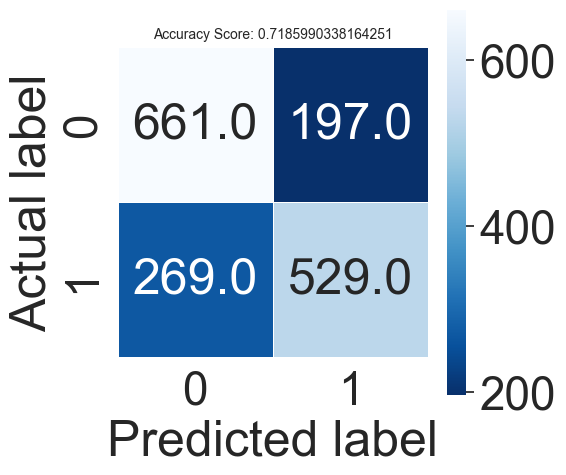

In [246]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 10);

plt.savefig('confusion_matrix.png')

In [254]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print(f1_score(y_test, predictions, average="macro"))
print(precision_score(y_test, predictions, average="macro"))
print(recall_score(y_test, predictions, average="macro"))

0.716799661787243
0.7197014129565449
0.7166517692833483


#### statsmodel

In [203]:
import statsmodels.formula.api as smf

In [207]:
smf_df = pd.DataFrame(X, columns = list(features_of_returner.keys()))
smf_df['pred_game'] = y

In [212]:
smf_df.columns

Index(['f', 'b', 'v', 'z', 'r', 's', 'u', 'y', 'f1', 'f2', 'f3', 'b1', 'b2',
       'b3', 'f1f1', 'f1f3', 'f3b3', 'f3b1', 'b3b1', 'b1f1', 'f1f2',
       'pred_game'],
      dtype='object')

In [213]:
# Define and fit model
log_reg = smf.logit("pred_game ~ f + b + v + z + r + s + u + y + f1 + f2 + f3 + b1 + b2 + b3+ f1f1 + f1f3 + f3b3 + f3b1 + b3b1 + f1f2", data=smf_df).fit()
# Summary of results
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.598755
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              pred_game   No. Observations:                 8278
Model:                          Logit   Df Residuals:                     8257
Method:                           MLE   Df Model:                           20
Date:                Wed, 30 Nov 2022   Pseudo R-squ.:                  0.1362
Time:                        00:01:30   Log-Likelihood:                -4956.5
converged:                       True   LL-Null:                       -5737.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0150      0.035     -0.426      0.670      -0.084       0.054
f              0.2976      0.

### Testing ingame *Pr(winning a game | current game information (rally))*

In [247]:
test_df = pd.DataFrame(X_test, columns = list(features_of_returner.keys()))

In [248]:
test_df.head(2)

,f,b,v,z,r,s,u,y,f1,f2,...,b1,b2,b3,f1f1,f1f3,f3b3,f3b1,b3b1,b1f1,f1f2
0,5,0,0,0,0,1,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [249]:
print(X_test[0])
print(logisticRegr.predict_proba([X_test[0]]))
print('58% chance of losing the game')

[5, 0, 0, 0, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[0.41675624 0.58324376]]
62% chance of losing the game


In [250]:
print(X_test[1])
print(logisticRegr.predict_proba([X_test[1]]))
print('63% chance of winning the game')

[1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[0.63796785 0.36203215]]
77% chance of winning the game


Without the information about the score, serves, etc..we are able to determine ingame winners solely based on the types of shots hit.

### Modelling Winner of Game given previous-games Information (prior rally information only)

### Get Winner of Next Game

In [138]:
def get_game_next_winner(df_test):
    winner_of_next_game = []
    count = 0 
    state_of_games = [0,0]
    state_of_sets = [0,0]
    len_of_match = len(df_test)
    i = 1 
    total = 0 
    for set1, set2, pts, gm1, gm2, pt_winner, winner_of_game in zip(df_test['Set1'], df_test['Set2'], df_test['Pts'], df_test['Gm1'], df_test['Gm2'], df_test['PtWinner'], df_test['winner_of_game']):
        if pts == '0-0' and (set1 > state_of_sets[0] or set2 > state_of_sets[1]):
            if i == len_of_match:
                count += 1
                df_test_new = df_test.iloc[:-count]
                #print(count, len_of_match, total, i, len(df_test_new))
                break
            winner_of_next_game.extend([winner_of_game] * count)

            #print(set1, set2, count)
            total += count
            state_of_sets = [set1, set2]
            state_of_games = [0,0]
            count = 1
            i += 1
            continue

        if pts == '0-0' and gm1+gm2 > 0:
            winner_of_next_game.extend([winner_of_game] * count)
            #print(gm1, gm2, count)
            total += count

            state_of_games = [gm1, gm2]
            count = 1
            i += 1
            continue

        if i == len_of_match:
            count += 1
            df_test_new = df_test.iloc[:-count]
            #print('hi')
            break
        i += 1
        count += 1
    
        
    #print(df_test['match_id'].values[0])
    df_test_new['winner_of_next_game'] = winner_of_next_game
    return df_test_new

In [139]:
match_dfs_next_game_winners = []
for match in match_dfs:
    match_dfs_next_game_winners.append(get_game_next_winner(match))

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/239839795.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_new['winner_of_next_game'] = winner_of_next_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/239839795.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_new['winner_of_next_game'] = winner_of_next_game
/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_3369/239839795.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [216]:
def get_features_new(match_example):
    feature_regex = '[fbvzrsuy]'
    shot_and_direction_basic = '[fb][123]'
    winner_games = []
    loser_games = []
    features_of_server = {
        'f': 0,
        'b': 0,
        'v': 0,
        'z': 0,
        'r': 0,
        's': 0,
        'u': 0,
        'y': 0,
        'f1': 0,
        'f2': 0,
        'f3': 0,
        'b1': 0,
        'b2': 0,
        'b3': 0,
        #'num_of_winners': 0,
        'f1f1': 0,
        'f1f3': 0,
        'f3b3': 0,
        'f3b1': 0,
        'b3b1': 0,
        'b1f1': 0,
        'f1f2': 0
    }
    features_of_returner = {
        'f': 0,
        'b': 0,
        'v': 0,
        'z': 0,
        'r': 0,
        's': 0,
        'u': 0,
        'y': 0,
        'f1': 0,
        'f2': 0,
        'f3': 0,
        'b1': 0,
        'b2': 0,
        'b3': 0,
        #'num_of_winners': 0,
        'f1f1': 0,
        'f1f3': 0,
        'f3b3': 0,
        'f3b1': 0,
        'b3b1': 0,
        'b1f1': 0,
        'f1f2': 0
    }
    i = 0
    for set1, set2, gm1, gm2, pts, first, second, is_ace, pt_winner, Svr, rallyCount, winner_of_game in zip(match_example['Set1'], match_example['Set2'], match_example['Gm1'], match_example['Gm2'], match_example['Pts'], match_example['1st'], match_example['2nd'], match_example['isAce'], match_example['PtWinner'], match_example['Svr'], match_example['rallyCount'], match_example['winner_of_game']):
        if is_ace == True or str(rallyCount) == 'nan' or int(rallyCount) <= 2:
            continue

        '''
        if pts == '0-0' and (set1 > state_of_sets[0] or set2 > state_of_sets[1]):
            if Svr == winner_of_game:
                winner_games.append(list(features_of_server.values()))
                loser_games.append(list(features_of_returner.values()))
            else:
                winner_games.append(list(features_of_returner.values()))
                loser_games.append(list(features_of_server.values()))

            features_of_server = {
                'f': 0,
                'b': 0,
                'v': 0,
                'z': 0,
                'num_of_winners': 0,
                'f1f1': 0,
                'f1f3': 0,
                'f3b3': 0,
                'f3b1': 0,
            }
            features_of_returner = {
                'f': 0,
                'b': 0,
                'v': 0,
                'z': 0,
                'num_of_winners': 0,
                'f1f1': 0,
                'f1f3': 0,
                'f3b3': 0,
                'f3b1': 0,
            }
            continue
            '''

        if pts == '0-0' and gm1+gm2 > 0:
            previous_server = match_example['Svr'].values[i-1]
            if previous_server == winner_of_game:
                winner_games.append(list(features_of_server.values()))
                loser_games.append(list(features_of_returner.values()))
            else:
                winner_games.append(list(features_of_returner.values()))
                loser_games.append(list(features_of_server.values()))

            features_of_server = {
                'f': 0,
                'b': 0,
                'v': 0,
                'z': 0,
                'r': 0,
                's': 0,
                'u': 0,
                'y': 0,
                'f1': 0,
                'f2': 0,
                'f3': 0,
                'b1': 0,
                'b2': 0,
                'b3': 0,
                #'num_of_winners': 0,
                'f1f1': 0,
                'f1f3': 0,
                'f3b3': 0,
                'f3b1': 0,
                'b3b1': 0,
                'b1f1': 0,
                'f1f2': 0
            }
            features_of_returner = {
                'f': 0,
                'b': 0,
                'v': 0,
                'z': 0,
                'r': 0,
                's': 0,
                'u': 0,
                'y': 0,
                'f1': 0,
                'f2': 0,
                'f3': 0,
                'b1': 0,
                'b2': 0,
                'b3': 0,
                #'num_of_winners': 0,
                'f1f1': 0,
                'f1f3': 0,
                'f3b3': 0,
                'f3b1': 0,
                'b3b1': 0,
                'b1f1': 0,
                'f1f2': 0
            }
            continue


        # extract features...
        rally = ''
        if str(second) == 'nan':
            rally = first
            shots = re.findall(shot_and_direction_new, first, flags=0)
        if str(second) != 'nan':
            rally = second
            shots = re.findall(shot_and_direction_new, second, flags=0)

        # winning shots
        if any(re.findall(r'\*|\#', rally)):
            if len(shots) >= 2:
                combined = shots[-2] + shots[-1]
                #print(combined)
                if pt_winner == Svr:
                    #features_of_server['num_of_winners'] += 1

                    if combined in features_of_server.keys():
                        features_of_server[combined] += 1
                        #print(features_of_server)

                if pt_winner != Svr:
                    #features_of_returner['num_of_winners'] += 1

                    if combined in features_of_returner.keys():
                        features_of_returner[combined] += 1
                        #print(features_of_returner)

        # general shots
        for i in range(len(shots)):
            if np.mod(i+1, 2) == 1: # returners shots
                shot = shots[i]
                #returner = returner + shot
                shot_type = re.search(feature_regex, shot)
                shot_type_direction = re.search(shot_and_direction_basic, shot)
                if shot_type:
                    features_of_returner[shot_type[0]] += 1
                if shot_type_direction:
                    features_of_returner[shot_type_direction[0]] += 1

            else: # servers shots
                shot = shots[i]
                #server = server + shot
                shot_type = re.search(feature_regex, shot)
                shot_type_direction = re.search(shot_and_direction_basic, shot)
                if shot_type:
                    features_of_server[shot_type[0]] += 1
                if shot_type_direction:
                    features_of_server[shot_type_direction[0]] += 1
        i += 1
    return winner_games, loser_games

In [217]:
X_next_game_winner, y_next_game_winner = [], []
for match in match_dfs_next_game_winners:
    match_df = match[['Set1', 'Set2', 'Gm1', 'Gm2', 'Pts', '1st', '2nd', 'isAce','PtWinner', 'Svr', 'rallyCount', 'winner_of_game', 'winner_of_next_game']]
    winner_games, loser_games = get_features_new(match_df)
    
    # add winning training data
    X_next_game_winner.extend(winner_games)
    y_next_game_winner.extend([1] * len(winner_games))
    
    # add losing training data
    X_next_game_winner.extend(loser_games)
    y_next_game_winner.extend([0] * len(loser_games))

#### sklearn

In [218]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_next_game_winner, y_next_game_winner, test_size=0.2, random_state=42)

In [219]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_new, y_train_new)

LogisticRegression()

In [220]:
score = logisticRegr.score(X_test_new, y_test_new)
print(score)

0.5081148564294632


#### statsmodel

In [221]:
import statsmodels.formula.api as smf

In [222]:
smf_df = pd.DataFrame(X_next_game_winner, columns = list(features_of_returner.keys()))
smf_df['pred_game'] = y_next_game_winner

In [223]:
# Define and fit model
log_reg = smf.logit("pred_game ~ f + b + v + z + r + s + u + y + f1 + f2 + f3 + b1 + b2 + b3+ f1f1 + f1f3 + f3b3 + f3b1 + b3b1 + f1f2", data=smf_df).fit()
# Summary of results
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.691980
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              pred_game   No. Observations:                 8010
Model:                          Logit   Df Residuals:                     7989
Method:                           MLE   Df Model:                           20
Date:                Wed, 30 Nov 2022   Pseudo R-squ.:                0.001685
Time:                        00:06:32   Log-Likelihood:                -5542.8
converged:                       True   LL-Null:                       -5552.1
Covariance Type:            nonrobust   LLR p-value:                    0.5410
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0034      0.032      0.106      0.916      -0.060       0.067
f             -0.0603      0.

## Results

Without the information about the score, serves, etc..we are able to determine winners of games at 72% accuracy solely based on the types of shots hit.

Moreover, using this model, we can estimate the probability of winning a game by using historical shot data between 2 players. 

For example, for player A vs player B, in order to find p(A winning a game against B as server or returner), we can calculate player A's average shot selections per game as a server and returner against B (our model parameters) and input them into a model to get p.

## Testing Model For A Match

In [340]:
#rafa_novak_df = wimbeldon_chart_df[wimbeldon_chart_df['match_id'] == '20180713-M-Wimbledon-SF-Rafael_Nadal-Novak_Djokovic']

In [366]:
rafa_novak_df = charting_df[charting_df['match_id'] == '20210611-M-Roland_Garros-SF-Rafael_Nadal-Novak_Djokovic']

In [367]:
rafa_novak_df.head(1)

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
62692,20210611-M-Roland_Garros-SF-Rafael_Nadal-Novak...,1,0,0,0.0,0.0,0-0,1 (1),1,0,...,1.0,False,False,False,False,True,False,2,0,6


In [379]:
player_map = {
    2: 'RN',
    1: 'ND'
}

In [344]:
rafa_serves = 0
djokovic_serves = 0

rafa_returns = 0
djokovic_returns = 0

rafa = True
novak = True

In [368]:
def get_features_test(match_example):
    rafa_serves = 0
    djokovic_serves = 0

    rafa_returns = 0
    djokovic_returns = 0

    rafa = True
    novak = True
    
    feature_regex = '[fbvzrsuy]'
    shot_and_direction_basic = '[fb][123]'
    winner_games = []
    loser_games = []
    features_of_server_RN = {
        'f': 0,
        'b': 0,
        'v': 0,
        'z': 0,
        'r': 0,
        's': 0,
        'u': 0,
        'y': 0,
        'f1': 0,
        'f2': 0,
        'f3': 0,
        'b1': 0,
        'b2': 0,
        'b3': 0,
        #'num_of_winners': 0,
        'f1f1': 0,
        'f1f3': 0,
        'f3b3': 0,
        'f3b1': 0,
        'b3b1': 0,
        'b1f1': 0,
        'f1f2': 0
    }
    features_of_returner_RN = {
        'f': 0,
        'b': 0,
        'v': 0,
        'z': 0,
        'r': 0,
        's': 0,
        'u': 0,
        'y': 0,
        'f1': 0,
        'f2': 0,
        'f3': 0,
        'b1': 0,
        'b2': 0,
        'b3': 0,
        #'num_of_winners': 0,
        'f1f1': 0,
        'f1f3': 0,
        'f3b3': 0,
        'f3b1': 0,
        'b3b1': 0,
        'b1f1': 0,
        'f1f2': 0
    }
    
    features_of_server_ND = {
        'f': 0,
        'b': 0,
        'v': 0,
        'z': 0,
        'r': 0,
        's': 0,
        'u': 0,
        'y': 0,
        'f1': 0,
        'f2': 0,
        'f3': 0,
        'b1': 0,
        'b2': 0,
        'b3': 0,
        #'num_of_winners': 0,
        'f1f1': 0,
        'f1f3': 0,
        'f3b3': 0,
        'f3b1': 0,
        'b3b1': 0,
        'b1f1': 0,
        'f1f2': 0
    }
    features_of_returner_ND = {
        'f': 0,
        'b': 0,
        'v': 0,
        'z': 0,
        'r': 0,
        's': 0,
        'u': 0,
        'y': 0,
        'f1': 0,
        'f2': 0,
        'f3': 0,
        'b1': 0,
        'b2': 0,
        'b3': 0,
        #'num_of_winners': 0,
        'f1f1': 0,
        'f1f3': 0,
        'f3b3': 0,
        'f3b1': 0,
        'b3b1': 0,
        'b1f1': 0,
        'f1f2': 0
    }
    
    for server, set1, set2, gm1, gm2, pts, first, second, is_ace, pt_winner, Svr, rallyCount in zip(match_example['Serving'], match_example['Set1'], match_example['Set2'], match_example['Gm1'], match_example['Gm2'], match_example['Pts'], match_example['1st'], match_example['2nd'], match_example['isAce'], match_example['PtWinner'], match_example['Svr'], match_example['rallyCount']):
        if is_ace == True or str(rallyCount) == 'nan' or int(rallyCount) <= 2:
            continue
            
        if server == 'RN' and rafa == True:
            rafa_serves += 1
            djokovic_returns += 1
            rafa = False
            novak = True
        if server == "ND" and novak == True:
            djokovic_serves += 1
            rafa_returns += 1
            rafa = True
            novak = False
            


        # extract features...
        rally = ''
        if str(second) == 'nan':
            rally = first
            shots = re.findall(shot_and_direction_new, first, flags=0)
        if str(second) != 'nan':
            rally = second
            shots = re.findall(shot_and_direction_new, second, flags=0)

        # winning shots
        if any(re.findall(r'\*|\#', rally)):
            if len(shots) >= 2:
                combined = shots[-2] + shots[-1]
                #print(combined)
                if player_map[pt_winner] == 'RN':
                    if combined in features_of_server_RN.keys():
                        if server == 'RN':
                                features_of_server_RN[combined] += 1
                                #print(features_of_server)
                        else:
                            features_of_returner_RN[combined] += 1
                            

                if player_map[pt_winner] == 'ND':
                    if combined in features_of_server_ND.keys():
                        if server == 'ND':
                                features_of_server_ND[combined] += 1
                                #print(features_of_server)
                        else:
                            features_of_returner_ND[combined] += 1

        # general shots
        for i in range(len(shots)):
            if np.mod(i+1, 2) == 1: # returners shots
                shot = shots[i]
                #returner = returner + shot
                shot_type = re.search(feature_regex, shot)
                shot_type_direction = re.search(shot_and_direction_basic, shot)
                
                if server == 'RN':
                    if shot_type:
                        features_of_returner_ND[shot_type[0]] += 1
                    if shot_type_direction:
                        features_of_returner_ND[shot_type_direction[0]] += 1
                if server == 'ND':
                    if shot_type:
                        features_of_returner_RN[shot_type[0]] += 1
                    if shot_type_direction:
                        features_of_returner_RN[shot_type_direction[0]] += 1

            else: # servers shots
                shot = shots[i]
                #server = server + shot
                shot_type = re.search(feature_regex, shot)
                shot_type_direction = re.search(shot_and_direction_basic, shot)
                
                
                if server == 'RN':
                    if shot_type:
                        features_of_server_RN[shot_type[0]] += 1
                    if shot_type_direction:
                        features_of_server_RN[shot_type_direction[0]] += 1
                if server == 'ND':
                    if shot_type:
                        features_of_server_ND[shot_type[0]] += 1
                    if shot_type_direction:
                        features_of_server_ND[shot_type_direction[0]] += 1

    return rafa_serves, rafa_returns, djokovic_serves, djokovic_returns, features_of_server_RN, features_of_returner_RN, features_of_server_ND, features_of_returner_ND, 

In [369]:
rafa_serves, rafa_returns, djokovic_serves, djokovic_returns, features_of_server_RN, features_of_returner_RN, features_of_server_ND, features_of_returner_ND = get_features_test(rafa_novak_df)

### Nadal

In [370]:
X_nadal_service = [np.array(list(features_of_server_RN.values()))/ rafa_serves]

In [371]:
X_nadal_return = [np.array(list(features_of_returner_RN.values())) / rafa_returns]

### Djokovic

In [372]:
X_djokovic_service = [np.array(list(features_of_server_ND.values()))/djokovic_serves]

In [373]:
X_djokovic_return = [np.array(list(features_of_returner_ND.values()))/djokovic_returns]

## Predictions 2021

In [374]:
logisticRegr.classes_

array([0, 1])

In [375]:
pred_nadal_service = logisticRegr.predict_proba(X_nadal_service)
pred_nadal_service

array([[0.50490189, 0.49509811]])

In [376]:
pred_nadal_return = logisticRegr.predict_proba(X_nadal_return)
pred_nadal_return

array([[0.70625226, 0.29374774]])

In [377]:
pred_djokovic_service = logisticRegr.predict_proba(X_djokovic_service)
pred_djokovic_service

array([[0.33279232, 0.66720768]])

In [378]:
pred_djokovic_return = logisticRegr.predict_proba(X_djokovic_return)
pred_djokovic_return

array([[0.61107452, 0.38892548]])

### Predictions 2015

In [385]:
rafa_novak_df_2015 = charting_df[charting_df['match_id'] == '20150603-M-Roland_Garros-QF-Novak_Djokovic-Rafael_Nadal']

In [386]:
rafa_serves, rafa_returns, djokovic_serves, djokovic_returns, features_of_server_RN, features_of_returner_RN, features_of_server_ND, features_of_returner_ND = get_features_test(rafa_novak_df_2015)

In [387]:
X_nadal_service = [np.array(list(features_of_server_RN.values()))/ rafa_serves]

In [388]:
X_nadal_return = [np.array(list(features_of_returner_RN.values())) / rafa_returns]

### Djokovic

In [389]:
X_djokovic_service = [np.array(list(features_of_server_ND.values()))/djokovic_serves]

In [390]:
X_djokovic_return = [np.array(list(features_of_returner_ND.values()))/djokovic_returns]

## Predictions

In [391]:
logisticRegr.classes_

array([0, 1])

In [392]:
pred_nadal_service = logisticRegr.predict_proba(X_nadal_service)
pred_nadal_service

array([[0.43088646, 0.56911354]])

In [393]:
pred_nadal_return = logisticRegr.predict_proba(X_nadal_return)
pred_nadal_return

array([[0.6262769, 0.3737231]])

In [394]:
pred_djokovic_service = logisticRegr.predict_proba(X_djokovic_service)
pred_djokovic_service

array([[0.36306352, 0.63693648]])

In [395]:
pred_djokovic_return = logisticRegr.predict_proba(X_djokovic_return)
pred_djokovic_return

array([[0.4762465, 0.5237535]])